In [159]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

data_dir = 'data'

In [22]:
df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'), low_memory=False)
df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,101.2,10.08,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,324.8,34.39,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,490.4,53.18,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,108.2,10.55,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,247.1,24.78,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675



TODO: Use a Gaussian Process Regressor with L1/L2/(L1+L2) Regularization + Adam/AdamW/SGD+Momentum

# Predict ABETA_bl #

In [179]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['ABETA_bl']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

kernel = (1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e1, 1e3))
          # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
          )

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=5e-1, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

gpr.fit(X_train, y_train)

,kernel,1**2 * RBF(length_scale=10)
,alpha,0.5
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RBF(length_scale=10)
,kernel__k1__constant_value,1.0


Training set performance

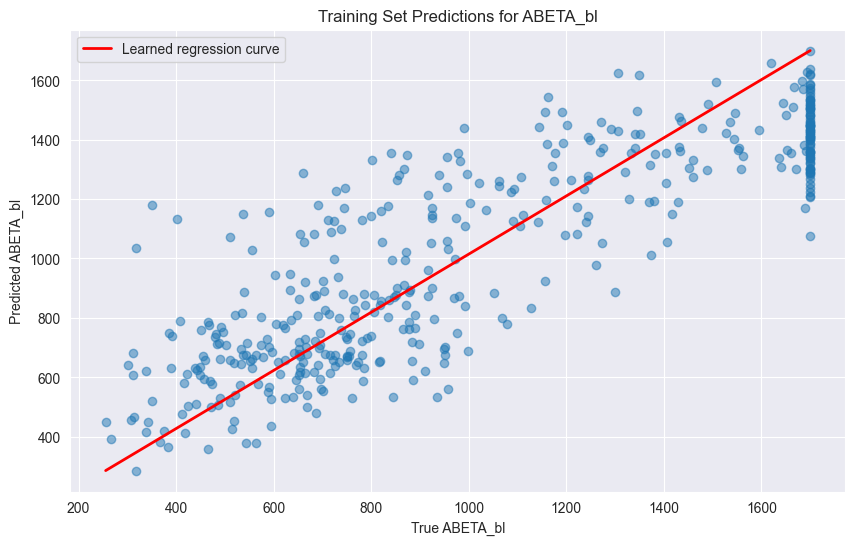

Training MSE: 57372.99
Training R^2: 0.72


In [180]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)
train_gradient = np.gradient(y_mean_train)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

Testing set performance

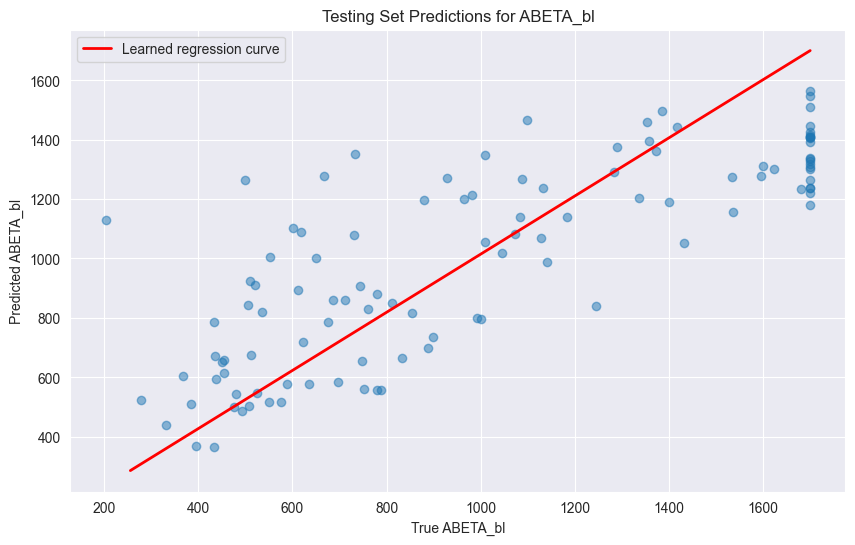

Testing MSE: 83838.37
Testing R^2: 0.63


In [181]:
y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)
test_gradient = np.gradient(y_mean_test)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_mean_test, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Testing Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_mean_test)
r2_test = r2_score(y_test, y_mean_test)

print(f'Testing MSE: {mse_test:.2f}')
print(f'Testing R^2: {r2_test:.2f}')

In [183]:
abs(test_gradient.mean() - train_gradient.mean())

np.float64(2.381971049846296)

# Predict PTAU_bl #

TODO: Explore other kernels for potentially better performance

In [185]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['PTAU_bl']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

kernel = (
    Matern(length_scale=1.0, nu=2.5)
    # + 1.0 * RBF(length_scale=1e0, length_scale_bounds=(1e-1, 1e3))
    # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
          )

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=25e-2, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

gpr.fit(X_train, y_train)

,kernel,"Matern(length_scale=1, nu=2.5)"
,alpha,0.25
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,1.0
,kernel__length_scale_bounds,"(1e-05, ...)"
,kernel__nu,2.5


Training set performance

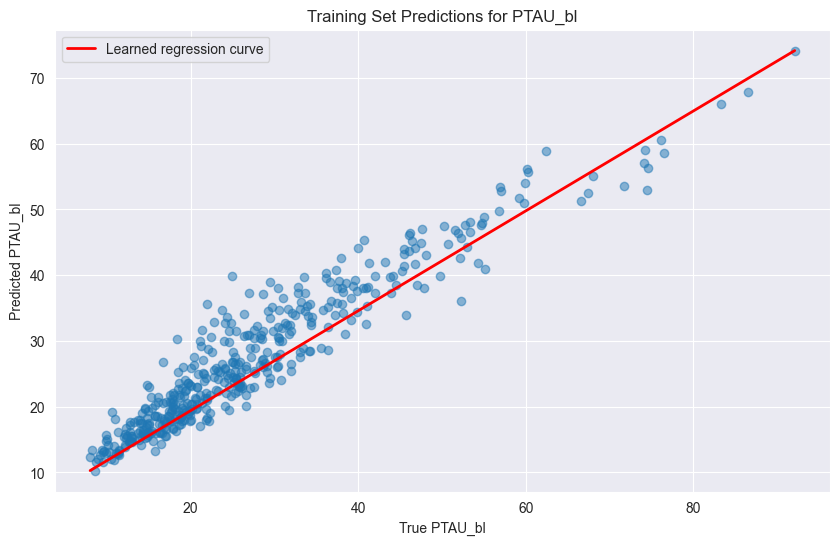

Training MSE: 26.48
Training R^2: 0.87


In [186]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)
train_gradient = np.gradient(y_mean_train)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# plt.plot(
#     [y_train.min(), y_train.max()],
#     [y_train.min(), y_train.max()],
#     'k--',
#     lw=2,
#     label='Perfect prediction',
# )
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True PTAU_bl')
plt.ylabel('Predicted PTAU_bl')
plt.title('Training Set Predictions for PTAU_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

Testing set performance

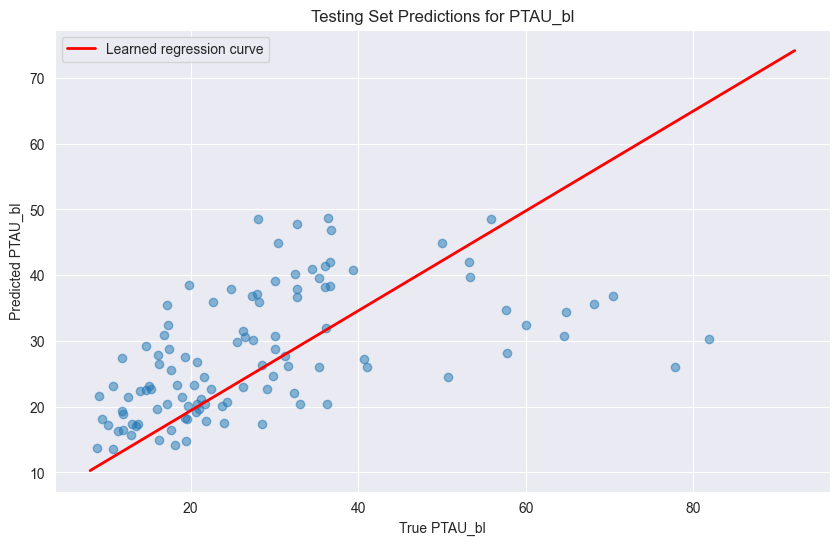

Testing MSE: 178.96
Testing R^2: 0.27


In [187]:
y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)
test_gradient = np.gradient(y_mean_test)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_mean_test, alpha=0.5)
# plt.plot(
#     [y_test.min(), y_test.max()],
#     [y_test.min(), y_test.max()],
#     'k--',
#     lw=2,
#     label='Perfect prediction',
# )
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True PTAU_bl')
plt.ylabel('Predicted PTAU_bl')
plt.title('Testing Set Predictions for PTAU_bl')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_mean_test)
r2_test = r2_score(y_test, y_mean_test)

print(f'Testing MSE: {mse_test:.2f}')
print(f'Testing R^2: {r2_test:.2f}')

In [188]:
abs(test_gradient.mean() - train_gradient.mean())

np.float64(0.09329594049103379)

# Predict TAU_bl #

In [189]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['TAU_bl']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

kernel = (1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1e5))
          # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
          )

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=5e-1, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

gpr.fit(X_train, y_train)

,kernel,1**2 * RBF(length_scale=10)
,alpha,0.5
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RBF(length_scale=10)
,kernel__k1__constant_value,1.0


Training set performance

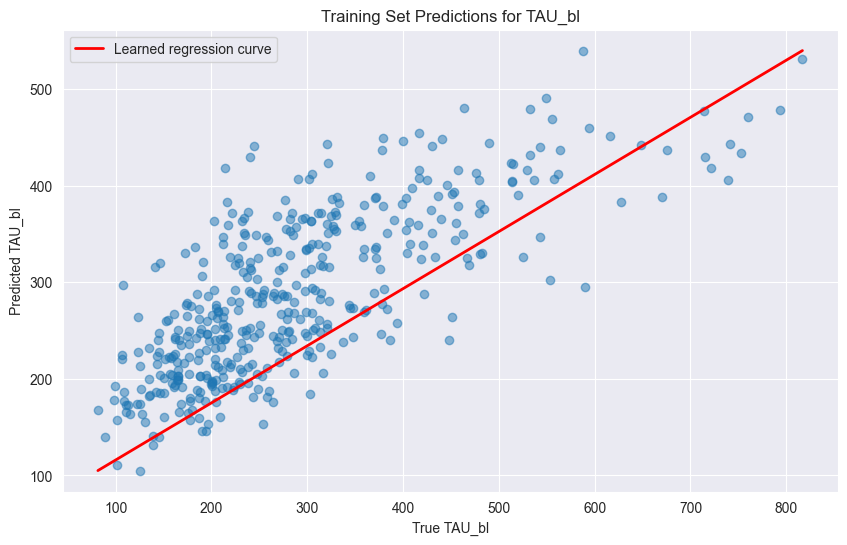

Training MSE: 8030.62
Training R^2: 0.55


In [190]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)
train_gradient = np.gradient(y_mean_train)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True TAU_bl')
plt.ylabel('Predicted TAU_bl')
plt.title('Training Set Predictions for TAU_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

Testing set performance

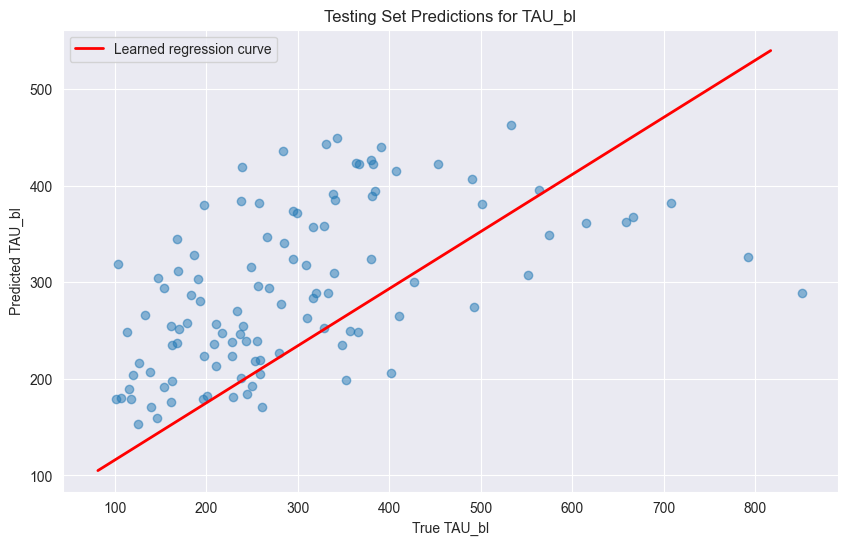

Testing MSE: 16391.98
Testing R^2: 0.26


In [192]:
y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)
test_gradient = np.gradient(y_mean_test)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_mean_test, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)

plt.xlabel('True TAU_bl')
plt.ylabel('Predicted TAU_bl')
plt.title('Testing Set Predictions for TAU_bl')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_mean_test)
r2_test = r2_score(y_test, y_mean_test)

print(f'Testing MSE: {mse_test:.2f}')
print(f'Testing R^2: {r2_test:.2f}')

In [193]:
abs(test_gradient.mean() - train_gradient.mean())

np.float64(0.2404801160096398)